## Brain Tumor Detection (98% Accurate)
In this project, I will emplement a residual convolutional neural network architecture to predict brain tumor. 

### About the data:
The data consist of X-Ray images of the human brain. It has two classes. 
- The first class of the brain scans that have brain tumors. 
- The other class is the class of brain scans that does not have tumors


### Plan:
The Aim of the project is to use ConvNets to predict whether or not a brain scan has a brain tumor. I will emplement a residual neural network architecture to achieve this goal.

Below are the steps to be taken:
- Load necessary packages for the analysis
- Display a sample of images from the dataset
- Emplement a data augmentation function
- Emplement the identity block
- Emplement the convolution block
- Emplement the Residual network by putting the identity block and convolution block together
- Train and evaluate the model

## Loading Packages


In [19]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

#### Loading Data

In [20]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "./Brain Tumor Data Set/Brain Tumor Data Set"
train_set = image_dataset_from_directory(directory,
                                         shuffle=True,
                                         image_size = IMG_SIZE,
                                         batch_size = BATCH_SIZE,
                                         validation_split = 0.2,
                                         subset= "training",
                                         seed=42)

test_set = image_dataset_from_directory(directory,
                                        shuffle=True,
                                        image_size = IMG_SIZE,
                                        batch_size = BATCH_SIZE,
                                        validation_split = 0.2,
                                        subset= "validation",
                                        seed=42)

Found 4514 files belonging to 2 classes.
Using 3612 files for training.
Found 4514 files belonging to 2 classes.
Using 902 files for validation.


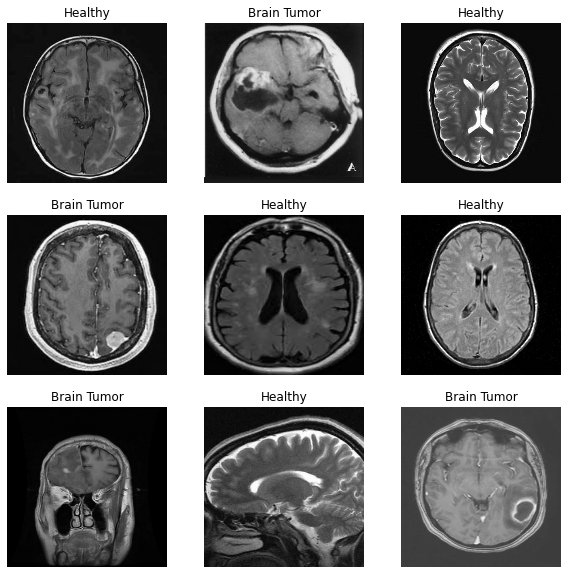

In [3]:
def plot_some_images(dataset) -> None:
    """
    plots a few images from the given dataset.
    The dataset is of type BatchDataset
    """
    class_names = dataset.class_names

    plt.figure(figsize=(10,10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3,3,i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")         
plot_some_images(train_set)

## Augmenting Data
The function below returns a sequential object that has some augmentations.

In [4]:
def data_augmentor() -> tf.keras.Sequential:
    """
    Perform two data augmentations namely:
        - A random horizontal flip
        - A random rotation
    return a tensorflow sequential object
    """
    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.3)
    ])
    return data_augmentation

## Identity Block Emplementation
The image below shows the identity block architecture to be used in this project.

#### Notations:

    - Conv: Convolution layer
    - BN  : Batch Normalization
    - Relu: the relu activation function

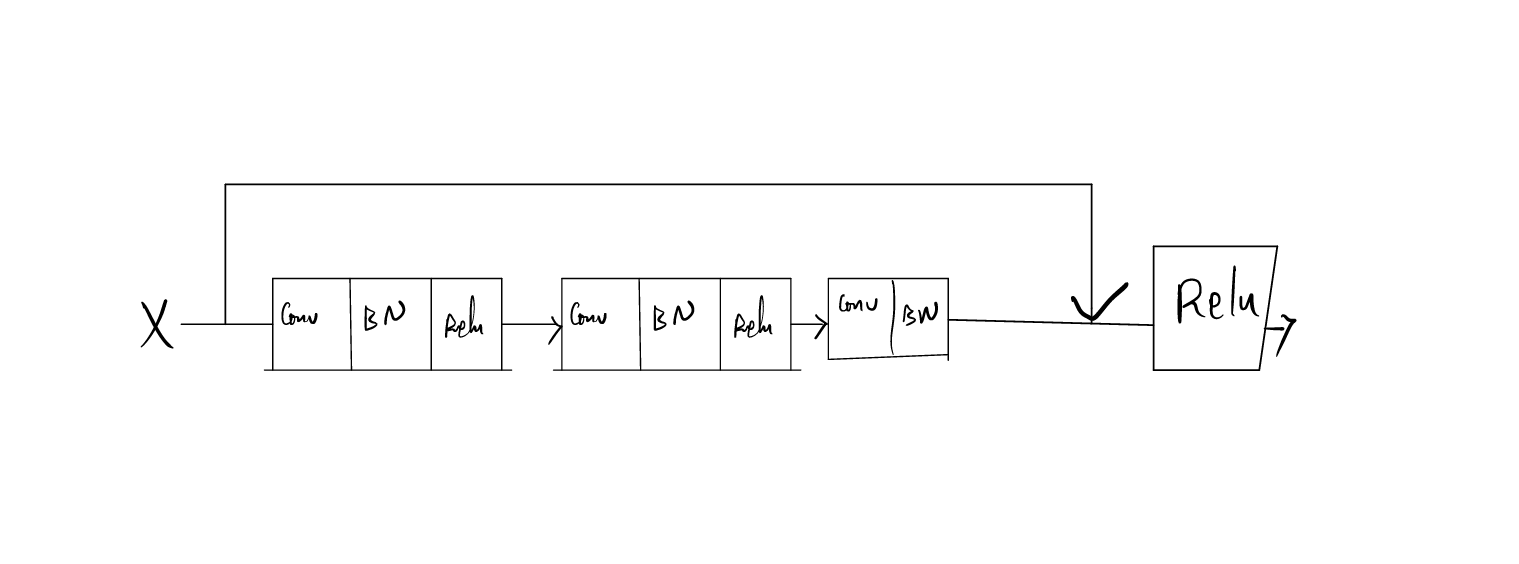

In [5]:
from IPython.display import Image
Image(filename= './images/identity_block.png')

In [6]:
def identity_block(X, f, filters, training = True, initializer = random_uniform):
    """
    Emplementation of the identity block in our resnet.
    Arguments: 
        - X: Input data, or from previous block
        - filters: the filters of each convolutional layer in our identity block
        - training: True denotes that we are using on the trainset. This is when the weights should be updated
        - initializer: an initialization of the weights
    """
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = 1, strides = 1, kernel_initializer = initializer(seed=0), padding = "valid")(X)
    X = BatchNormalization(axis=3)(X, training = training)
    X = Activation("relu")(X)
    
    X = Conv2D(filters = F2, kernel_size = f, strides = 1, kernel_initializer = initializer(seed=0), padding = "same")(X)
    X = BatchNormalization(axis=3)(X, training = training)
    X = Activation("relu")(X)
    
        
    X = Conv2D(filters = F3, kernel_size = 1, strides = 1, kernel_initializer = initializer(seed=0), padding = "valid")(X)
    X = BatchNormalization(axis=3)(X, training = training)

    X = Add()([X_shortcut, X])
    
    X = Activation("relu")(X)
    return X

## Convolution Block Emplementation


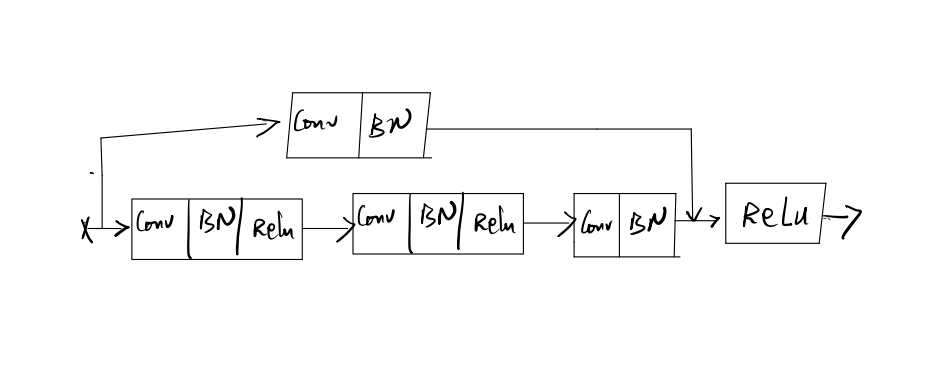

In [7]:
Image(filename="images/Conv Block.png")

In [8]:
def convolutional_block(X, f, filters, s=2,   training = True, initializer= glorot_uniform):
    '''
    Emplementation of the convolution block in our residual network
    Arguments: 
        - X: Input data, or from previous block
        - filters: the filters of each convolutional layer in our identity block
        - training: True denotes that we are using on the trainset. This is when the weights should be updated
        - initializer: an initialization of the weights
    '''
    # obtaining filters
    F1, F2, F3 = filters
    
    # keeping a shortcut to be outbranched
    X_shortcut = X
    
    # First main branch component
    X = Conv2D(filters = F1, kernel_size = 1, strides = s, kernel_initializer = initializer(seed=0), padding = "valid")(X)
    X = BatchNormalization(axis=3)(X, training = training)
    X = Activation("relu")(X)
    
    # Second main branch component
    X = Conv2D(filters = F2, kernel_size = f, strides = 1, kernel_initializer = initializer(seed=0), padding = "same")(X)
    X = BatchNormalization(axis=3)(X, training = training)
    X = Activation("relu")(X)
    
    # Third main branch component
    X = Conv2D(filters = F3, kernel_size = 1, strides = 1, kernel_initializer = initializer(seed=0), padding = "valid")(X)
    X = BatchNormalization(axis=3)(X, training = training)
    
    # Component of the subbranch
    shortcut_conv = Conv2D(filters = F3, kernel_size=1, strides=s, kernel_initializer= initializer(seed=0), padding = 'valid')(X_shortcut)
    shortcut_conv = BatchNormalization(axis=3)(shortcut_conv, training = training)
    
    X = Add()([shortcut_conv, X])
    X = Activation('relu')(X)

    return X

## Residual Network Emplementation

In [9]:
def ResNet(input_shape = (160, 160, 3), classes = 2):
    '''
    Puts different combinations of the convolution blocks and identity blocks to make a residual network
    '''
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3,3))(X_input)
    
    X = Conv2D(filters= 64, kernel_size = 7, strides = 2, padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation("relu")(X)
    X = MaxPooling2D((3,3), strides = 2)(X)
    
    X = convolutional_block(X, f=3, filters = ( 64, 64, 256), s=1)
    X = identity_block(X, 3, filters=(64, 64, 256))
    X = identity_block(X, 3, filters=(64, 64, 256))
    
    X = convolutional_block(X, f=3, filters = ( 128, 128, 512), s=2)
    X = identity_block(X, 3, filters=(128, 128, 512))
    X = identity_block(X, 3,  filters=(128, 128, 512))
    X = identity_block(X, 3, filters=(128, 128, 512))
    
    
    X = convolutional_block(X, f=3, filters = ( 256, 256, 1024), s=2)
    X = identity_block(X, 3, filters=(256, 256, 1024))
    X = identity_block(X, 3, filters=(256, 256, 1024))

    
    X = convolutional_block(X, f=3, filters = ( 512, 512, 2048), s=2)
    X = identity_block(X, 3, filters=(512, 512, 2048))
    
    X = AveragePooling2D(2,2)(X)
    
    X = Flatten()(X)
    X = Dense(1, activation = 'sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X)
    return model

model = ResNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 83, 83, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 83, 83, 64)  256         ['conv2d[0][0]']             

### Training Model

In [10]:
'''Creating a Checkpoint path'''
checkpoint_filepath = './tmp/checkpoint'

'''A checkpoint that saves the best model seen so far'''
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


'''Compiling the model'''
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

'''Fitting the model'''
model.fit(train_set, validation_data= test_set, epochs=30,  callbacks=[model_checkpoint])

Epoch 1/30


2022-06-24 03:36:08.922448: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


113/113 [==============================] - 67s 443ms/step - loss: 0.9337 - accuracy: 0.7182 - val_loss: 0.6597 - val_accuracy: 0.8049
Epoch 2/30
113/113 [==============================] - 42s 369ms/step - loss: 0.5814 - accuracy: 0.8281 - val_loss: 0.3737 - val_accuracy: 0.8858
Epoch 3/30
113/113 [==============================] - 41s 365ms/step - loss: 0.3431 - accuracy: 0.8846 - val_loss: 0.3005 - val_accuracy: 0.8880
Epoch 4/30
113/113 [==============================] - 40s 348ms/step - loss: 0.3127 - accuracy: 0.9092 - val_loss: 0.7744 - val_accuracy: 0.7517
Epoch 5/30
113/113 [==============================] - 41s 366ms/step - loss: 0.6156 - accuracy: 0.8126 - val_loss: 0.3205 - val_accuracy: 0.8958
Epoch 6/30
113/113 [==============================] - 41s 359ms/step - loss: 0.2325 - accuracy: 0.9228 - val_loss: 0.2652 - val_accuracy: 0.9157
Epoch 7/30
113/113 [==============================] - 40s 357ms/step - loss: 0.1860 - accuracy: 0.9466 - val_loss: 0.1978 - val_accuracy: 0.9

In [15]:
import pandas as pd
df = pd.DataFrame.from_dict(model.history.history)
df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.933696,0.718162,0.659714,0.804878
1,0.581428,0.828073,0.373736,0.885809
2,0.343062,0.884551,0.300469,0.888027
3,0.312668,0.909192,0.774420,0.751663
4,0.615621,0.812569,0.320515,0.895787


In [16]:
def plot_history(data : pd.DataFrame, first_metric: str, second_metric: str, xlab:str, ylab:str, title:str) -> None:
    '''
    Plots the history of out training. 
    '''
    plt.plot(df[first_metric])
    plt.plot(df[second_metric])
    plt.legend([first_metric, second_metric], loc='upper left')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.grid()
    

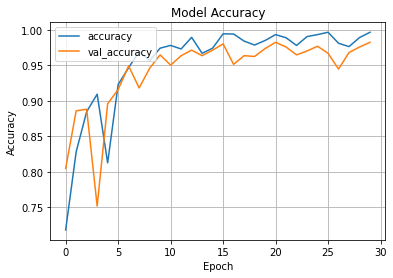

In [17]:
plot_history(df, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Model Accuracy')

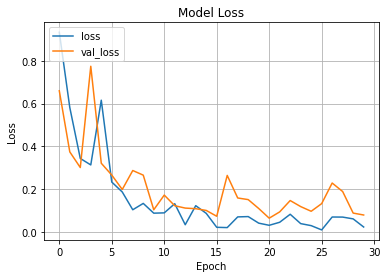

In [18]:
plot_history(df, 'loss', 'val_loss', 'Epoch', "Loss", 'Model Loss')